In [41]:
%reset -f

import numpy as np
import matplotlib.pyplot as plt

# Plots LaTeX-Style
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

In [42]:
# Define System
T = 1
h = 0.1
n = int(T/h) + 1

A = np.array([[0, 1], [-1, 0]])
Ak = np.array([[1, h],[-h, 1]])
Ck = np.array([1, 0]) # z = x
x0 = np.array([1, 1])

x_var = 0.1
z_var = 0.1
Q = np.array([[x_var, 0], [0, x_var]])
R = z_var

# Real dynamics
x_real = np.zeros((n, 2))
x_real[0] = x0
for i in range(1, n):
    x_real[i] = x_real[i-1] + h * A @ x_real[i-1]


z = np.zeros(n)
z[0] = Ck @ x0 + R * np.random.normal()

In [43]:
# Kalman
x_pred = np.zeros((n, 2))
Cov_pred = np.zeros((n, 2, 2))

x_pred[0] = x0
Cov_pred[0] = Q

x_filt = np.zeros((n, 2))
Cov_filt = np.zeros((n, 2, 2))

x_filt[0] = x0
Cov_filt[0] = Q

# Nearby filters
x_fnear_f = np.zeros((10, n, 2))
fnear_amp = [0.9, 0.92, 0.96, 0.98, 0.99, 1.02, 1.06, 1.1, 1.15, 1.2]

# Avg error
e_filters = np.zeros(11)


In [44]:
for s in range(100):
    for t in range(n):
        x_pred[t] = Ak @ x_pred[t-1]
        Cov_pred[t] = Ak @ Cov_pred[t-1] @ Ak.T + Q

        z[t] = Ck @ x_real[t] + R * np.random.normal()
        #Kalman
        K = Cov_pred[t] @ Ck.T * 1/(Ck @ Cov_pred[t] @ Ck.T + R)
        x_filt[t] = x_pred[t] + K * (z[t] - Ck @ x_pred[t])
        # Cov_filt[t] = Cov_pred[t] - K * Ck @ Cov_pred[t]
        e_filters[5] += np.linalg.norm(x_filt[t] - x_real[t])/(n*100)

        #Filters 1-10
        for f in range(0, 5):
            Kf = K*fnear_amp[f]
            x_fnear_f[f-1, t] = x_pred[t] + Kf * (z[t] - Ck @ x_pred[t])
            e_filters[f] += np.linalg.norm(x_fnear_f[f-1, t] - x_real[t])/(n*100)
        for f in range(6, 11):
            Kf = K*fnear_amp[f-1]
            x_fnear_f[f-1, t] = x_pred[t] + Kf * (z[t] - Ck @ x_pred[t])
            e_filters[f] += np.linalg.norm(x_fnear_f[f-1, t] - x_real[t])/(n*100)

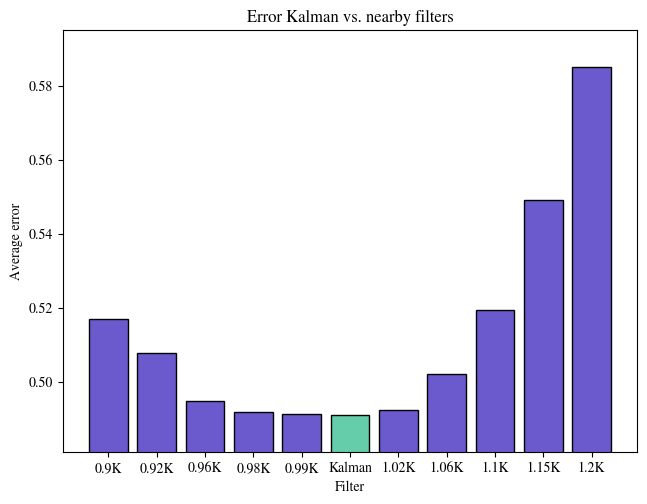

In [45]:
fig, ax = plt.subplots()
fig.tight_layout()

x_axis = [str(fnear_amp[0]) + 'K', str(fnear_amp[1]) + 'K', str(fnear_amp[2]) + 'K', str(fnear_amp[3]) + 'K', str(fnear_amp[4]) + 'K', 'Kalman', str(fnear_amp[5]) + 'K', str(fnear_amp[6]) + 'K', str(fnear_amp[7]) + 'K', str(fnear_amp[8]) + 'K', str(fnear_amp[9]) + 'K']
barlist = ax.bar(x_axis, e_filters, color='slateblue', edgecolor='k')
barlist[5].set_color('mediumaquamarine')
barlist[5].set_edgecolor('k')
ax.set_ylim(bottom=np.amin(e_filters)-0.01, top=np.amax(e_filters)+0.01)

ax.set_xlabel('Filter')
ax.set_ylabel('Average error')
ax.set_title('Error Kalman vs. nearby filters')
plt.savefig('HW3_3_error.png', dpi=300)
plt.show()